## Annotation enrichemts
enrichments for the lead variant for each phenotype, to rule out susie funny bussiness

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress
import upsetplot as up



from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [163]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

#tissue_ids = ['Adipose_Subcutaneous']
tissue_ids = tissue_ids[:11]

# load data

In [164]:
pcqtls = [load_pc_cis(config, tissue_id) for tissue_id in tissue_ids]
pcqtls = pd.concat([df.assign(tissue_id=n) for df, n in zip(pcqtls, tissue_ids)])

eqtls = [load_e_cis(config, tissue_id) for tissue_id in tissue_ids]
eqtls = pd.concat([df.assign(tissue_id=n) for df, n in zip(eqtls, tissue_ids)])

qtls = pd.concat([pcqtls, eqtls]).reset_index()
qtls = qtls[qtls['qval'] < .05]
qtls['type'] = np.where(qtls['phenotype_id'].str.contains('pc'), 'pcqtl', 'eqtl')
# for the permutation ones which allow multiple vars per phenotype (but seemingly not overlap between phenotypes)
#qtls['phenotype_var_id'] = qtls['phenotype_id'].astype(str) + '_' + qtls['rank'].astype(str) 

In [29]:
# load in the gene information 
gid_gencode, full_gencode = load_gencode()

In [165]:
# create overlap columns
def shared_lead_var(row, qtl_df):
    matched_cluster_df = qtl_df[qtl_df['cluster_id']==row.cluster_id]
    shared_qtls = matched_cluster_df[matched_cluster_df['variant_id'] == row['variant_id']]
    #shared_qtls = shared_qtls[~(shared_qtls['phenotype_var_id']==row['phenotype_var_id'])]
    return str(shared_qtls['phenotype_id'].to_list())
    
qtls['e_samelead'] = qtls.progress_apply(shared_lead_var, axis=1, args=(qtls[qtls['type']=='eqtl'],))
qtls['pc_samelead'] = qtls.progress_apply(shared_lead_var, axis=1, args=(qtls[qtls['type']=='pcqtl'],))
qtls['num_e_samelead'] = qtls['e_samelead'].apply(ast.literal_eval).apply(len)
qtls['num_pc_samelead'] = qtls['pc_samelead'].apply(ast.literal_eval).apply(len)
   

100%|██████████████████████████████████████████████████████████████████████████| 34901/34901 [01:23<00:00, 415.69it/s]


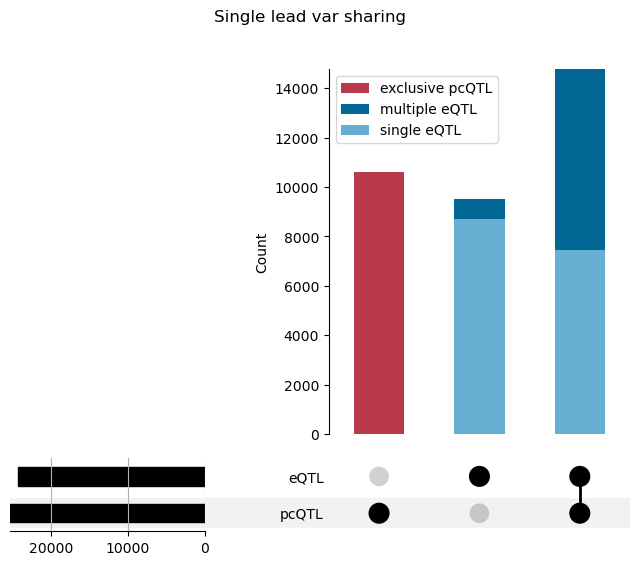

In [169]:
qtls['eQTL'] = qtls['num_e_samelead'] > 0
qtls['pcQTL'] = qtls['num_pc_samelead'] > 0
qtls['multiple_e_shared_label'] = np.where((qtls['num_e_samelead'] > 1), 'multiple eQTL', 'single eQTL')
qtls['multiple_e_shared_label'] = np.where(qtls['num_e_samelead'] > 0, qtls['multiple_e_shared_label'], 'exclusive pcQTL')

upset = qtls.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('Single lead var sharing')
plt.show()

In [170]:
qtls['exclusive_label'] = np.where((qtls['num_e_samelead'] > 0), np.where((qtls['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')
qtls['pc_num'] = np.where(qtls['type']=='pcqtl',  qtls['phenotype_id'].str.split('_pc').str[-1], 0)
qtls['pc_num'] = qtls['pc_num'].astype(int)
# add in cluster size
qtls['cluster_size'] = qtls['cluster_id'].str.split('_').apply(len)
# split first, last, and middle pcs
qtls['pc_order'] = 'middle'
qtls.loc[qtls['pc_num'] == qtls['cluster_size'],'pc_order'] = 'last'
qtls.loc[qtls['pc_num'] == 1,'pc_order'] = 'first'
qtls.loc[qtls['type'] == 'eqtl','pc_order'] = 'eqtl'

<AxesSubplot: xlabel='pc_order', ylabel='Percent'>

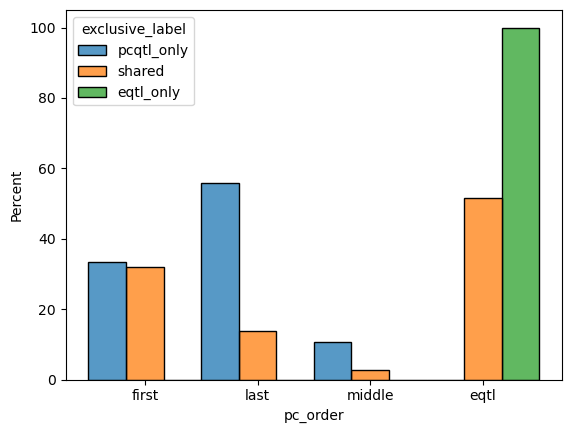

In [171]:
sns.histplot(qtls, hue='exclusive_label', x='pc_order', common_norm=False, multiple='dodge', stat='percent')

# some other annotaiton categories
from data used in cluster annotations

* ABC enhancer
* CTCF site
* near tad boundry


pc eigenvalue

In [173]:
# pc_dfs = []
# for tissue_id in load_tissue_ids(config):    
#     pc_df = load_pc(config, tissue_id)
#     expression_df = load_cluster_expression(config, tissue_id)  
#     sample_ids = pc_df.columns[pc_df.columns.str.contains('GTEX')]
#     for idx, row in tqdm(pc_df.iterrows(), total=pc_df.shape[0]):
#         expression_cluster = expression_df[expression_df['cluster_id'] == row['cluster_id']].reset_index()
#         gene_variances = []
#         for i in range(len(expression_cluster)):
#             # pull the right data
#             pc_values = row[sample_ids].astype('float')
#             expression_values = expression_cluster.loc[i, sample_ids].astype('float')
#             # get the r squared value
#             slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
#             gene_variances.append((r_value**2)*100)
#         gene_variances.sort()
#         pc_df.loc[idx, 'largest_variance'] = gene_variances[-1]
#         pc_df.loc[idx, 'second_largest_variance'] = gene_variances[-2]
#         pc_df.loc[idx, 'total_variance'] = sum(gene_variances)
#         pc_df.loc[idx, 'variance_list'] = str(gene_variances)
#     pc_df['tissue_id'] = tissue_id
#     pc_dfs.append(pc_df)

# #write out
# pc_df = pd.concat(pc_dfs)
# pc_df = pc_df.copy()
# pc_df['chr'] = pc_df['#chr']
# pc_df = pc_df[['chr', 'start', 'end', 'gene_id', 'largest_variance', 'second_largest_variance', 'total_variance', 'variance_list']]
# pc_df.to_csv('{}/{}/pc_annotated.csv'.format(prefix, config['pc_output_dir']), index=None)

100%|████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:15<00:00, 130.65it/s]


In [180]:
#load in 
pc_df = pd.read_csv('{}/{}/pc_annotated.csv'.format(prefix, config['pc_output_dir']))

In [181]:
pcqtls = qtls[qtls['type']=='pcqtl']
pcqtls = pd.merge(pcqtls, pc_df, left_on='phenotype_id', right_on = 'gene_id')

In [182]:
pc_df['has_pcqtl'] = pc_df['gene_id'].isin(qtls['phenotype_id'].unique())
pc_df['has_unique_pcqtl'] = pc_df['gene_id'].isin(qtls[qtls['num_e_samelead']==0]['phenotype_id'].unique())
pc_df['qtl_label'] = np.where(pc_df['has_pcqtl'], np.where(pc_df['has_unique_pcqtl'], 'unique pcqtl', 'shared pcqtl'), 'no pcqtl')

In [183]:
pc_df['pc_num'] = pc_df['gene_id'].str.split('_pc').str[-1].astype(int)
pc_df['cluster_size'] = pc_df['gene_id'].str.split('_').apply(len) - 1
pc_df['pc_order'] = 'middle'
pc_df.loc[pc_df['pc_num'] == pc_df['cluster_size'],'pc_order'] = 'last'
pc_df.loc[pc_df['pc_num'] == 1,'pc_order'] = 'first'

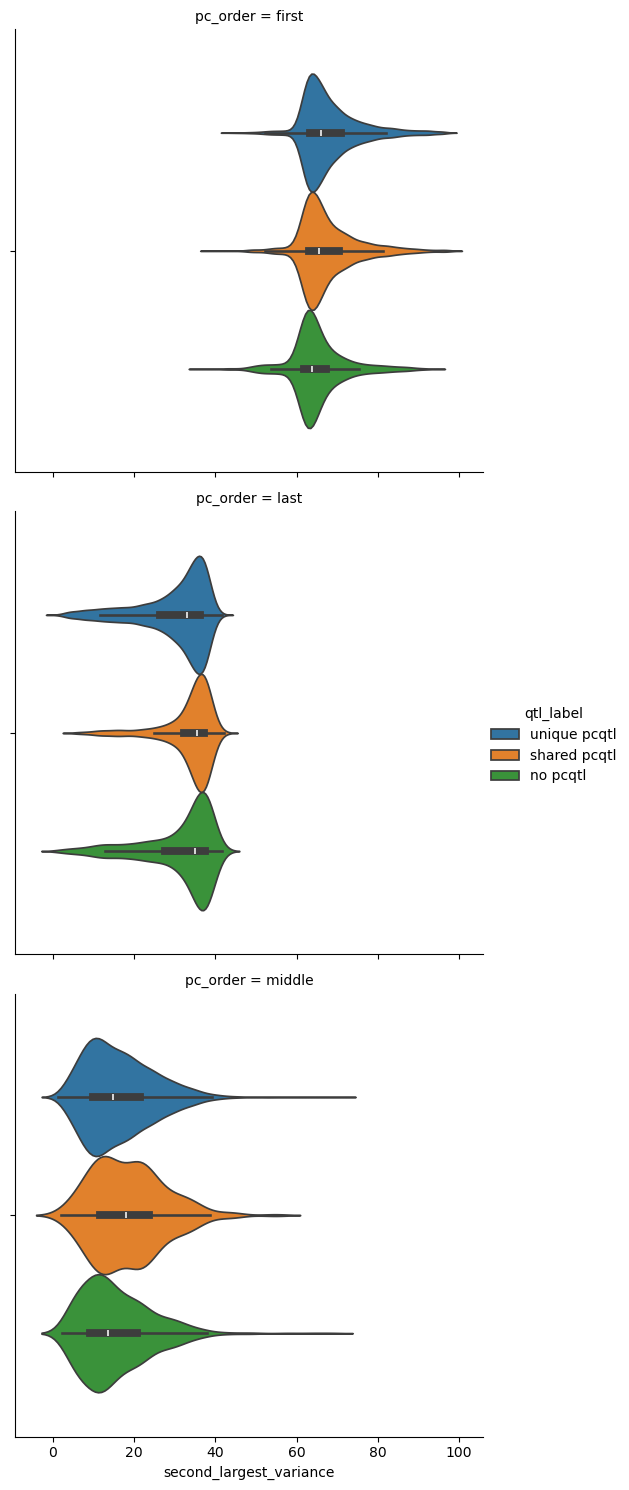

In [188]:
sns.catplot(pc_df, kind='violin', x='second_largest_variance', row='pc_order', hue='qtl_label')

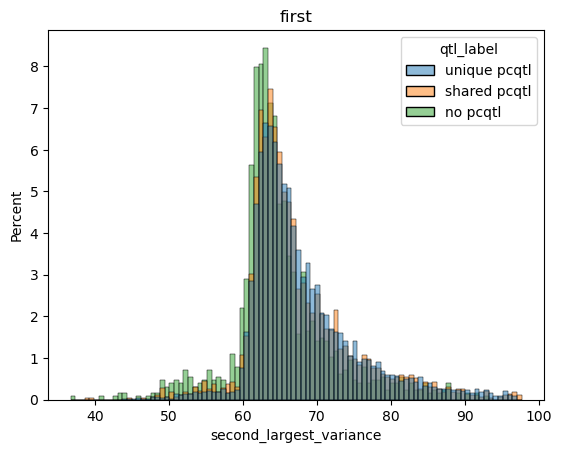

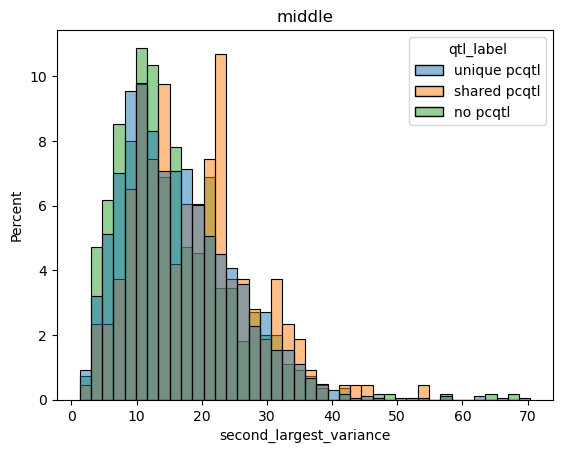

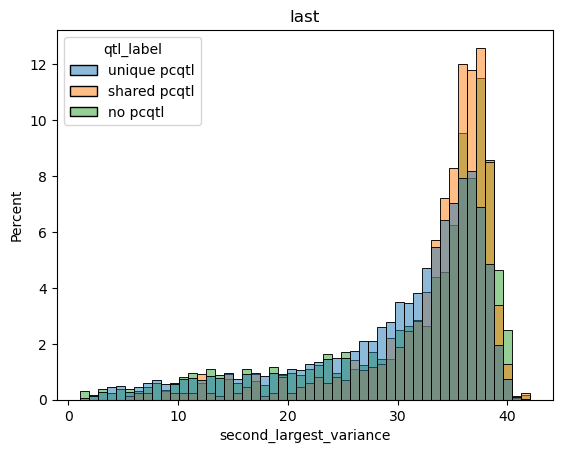

In [189]:
# are pcs that explain more varience more likely to have a pcqtl? 
for order in ['first', 'middle', 'last']:
    ax = sns.histplot(data=pc_df[pc_df['pc_order']==order], hue='qtl_label', 
                      x='second_largest_variance', common_norm=False, stat='percent', 
                      hue_order=['unique pcqtl', 'shared pcqtl', 'no pcqtl'])
    ax.set_title(order)

    plt.show()

<AxesSubplot: xlabel='largest_variance', ylabel='cluster_size'>

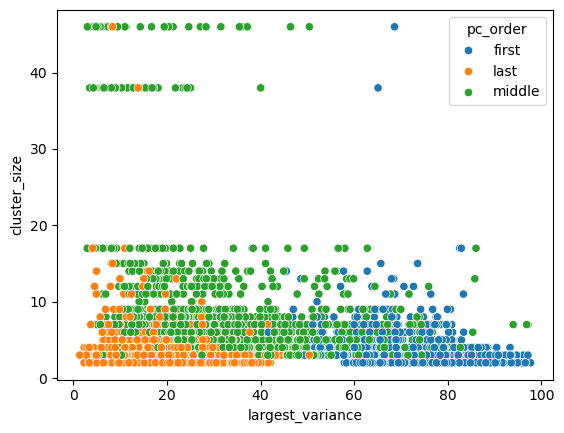

In [190]:
sns.scatterplot(pc_df, x='largest_variance', y='cluster_size', hue='pc_order')

expression level

In [29]:
def load_avg_exression(avg_expression_path = f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv'):
    tissue_avg_expression = pd.read_csv(avg_expression_path, sep='\t', index_col=0)
    return tissue_avg_expression

def annotate_avg_expression(vep_df, tissue_avg_expression):
    for idx, row in tqdm(vep_df.iterrows(), total=len(vep_df)):
        transcript_list = row['cluster_id'].split('_')
        cluster_avg_expression = tissue_avg_expression.loc[row['tissue_id'],transcript_list]
        vep_df.loc[idx, 'avg_expression'] = np.mean(cluster_avg_expression)
        vep_df.loc[idx, 'avg_log_expression'] = np.mean(np.log10(cluster_avg_expression))
        vep_df.loc[idx, 'median_expression'] = np.median(cluster_avg_expression)
        vep_df.loc[idx, 'min_expression'] = np.min(cluster_avg_expression)



annotate_avg_expression(qtls, load_avg_exression())

NameError: name 'qtls' is not defined

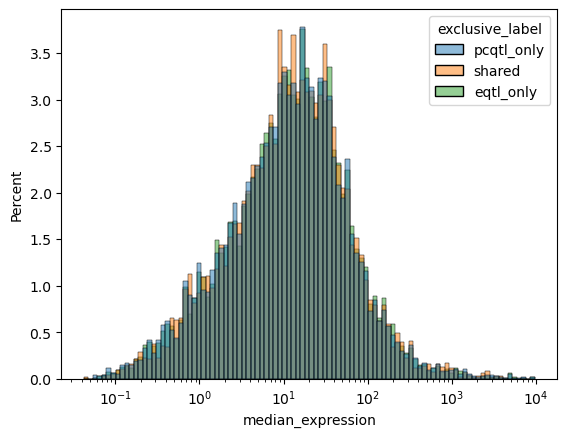

In [192]:
ax=sns.histplot(data=qtls, hue='exclusive_label', x='median_expression', stat='percent', common_norm=False, bins=100, log_scale=True)
#ax.set_yscale('log')

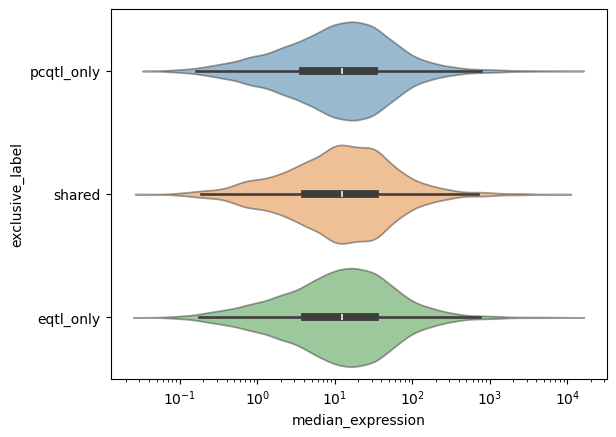

In [193]:
ax=sns.violinplot(data=qtls, hue='exclusive_label', x='median_expression', y='exclusive_label', log_scale=True, alpha=.5)


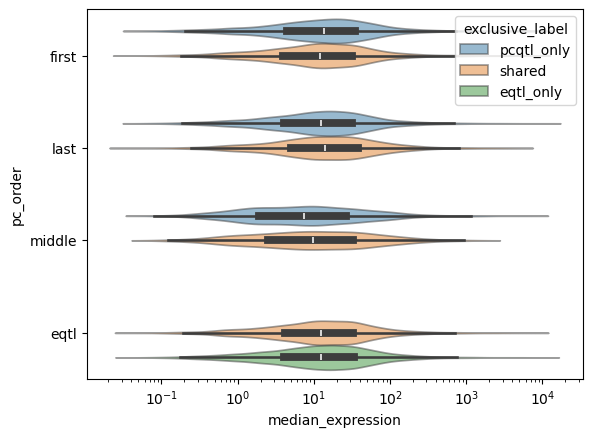

In [194]:
ax=sns.violinplot(data=qtls, hue='exclusive_label', x='median_expression', y='pc_order', log_scale=True, alpha=.5)


effect size

In [195]:
qtls['abs_slope'] = qtls['slope'].abs()

<AxesSubplot: xlabel='abs_slope', ylabel='Count'>

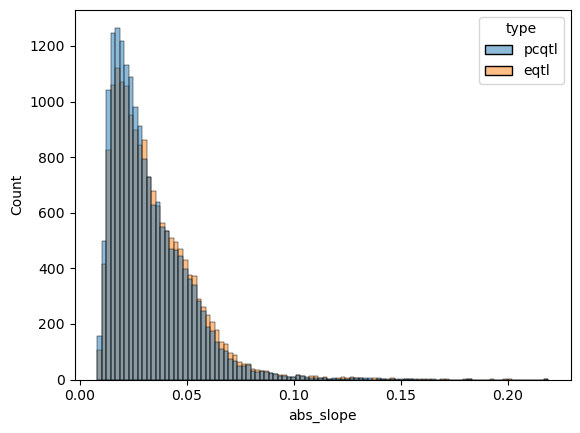

In [196]:
sns.histplot(qtls, x='abs_slope', hue='type', common_norm=False, bins=100)

abc

In [138]:
full_abc_path= '/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt.gz'
abc_match_path='/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/ABC_matched_gtex.csv'   
full_abc_pred_df = pd.read_csv(full_abc_path, sep='\t')
abc_gtex_match = pd.read_csv(abc_match_path)

full_abc_pred_df = full_abc_pred_df[full_abc_pred_df['CellType'].isin(abc_gtex_match['ABC_biosample_id'])]
gene_enhancer_df = pd.merge(full_gencode[['transcript_id', 'gene_name']], full_abc_pred_df[['chr', 'start', 'end', 'TargetGene','name','class', 'ABC.Score', 'CellType']], left_on='gene_name', right_on='TargetGene', how='left')
gene_enhancer_df.rename(columns={'name':'enhancer'}, inplace=True)
gene_enhancer_df.set_index('transcript_id', inplace=True)
gene_enhancer_df.dropna(inplace=True)

gene_enhancer_df['chr'] = gene_enhancer_df['chr'].str.split('chr').str[1]
gene_enhancer_df = gene_enhancer_df[gene_enhancer_df['chr'].isin(f'{i+1}' for i in range(22))]
gene_enhancer_df['chr'] = gene_enhancer_df['chr'].astype(int)
gene_enhancer_df['enhancer_start'] = gene_enhancer_df['enhancer'].str.split(':').str[1].str.split('-').str[0].astype(int)
gene_enhancer_df['enhancer_end'] = gene_enhancer_df['enhancer'].str.split(':').str[1].str.split('-').str[1].astype(int)

<AxesSubplot: xlabel='enhancer_size', ylabel='Count'>

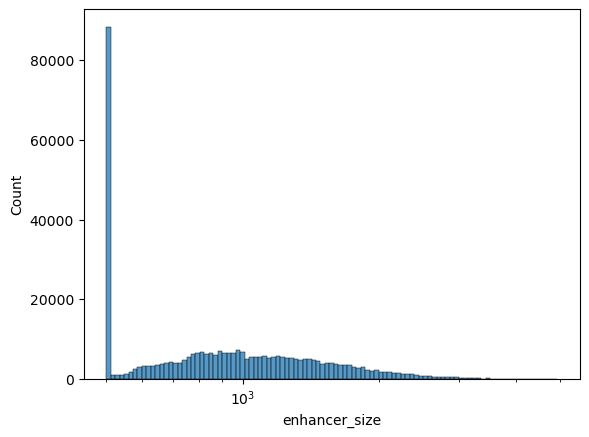

In [139]:
gene_enhancer_df['enhancer_size'] = gene_enhancer_df['enhancer_end'] - gene_enhancer_df['enhancer_start']
sns.histplot(gene_enhancer_df['enhancer_size'], log_scale=True)

In [197]:
qtls['chr'] = qtls['variant_id'].str.split('_').str[0].str.strip('chr').astype(int)
qtls['position'] = qtls['variant_id'].str.split('_').str[1].astype(int)

In [198]:
for tissue_id, sub_qtl in qtls.groupby('tissue_id'):
    tissue_enhancers = gene_enhancer_df[gene_enhancer_df['CellType'] == abc_gtex_match[abc_gtex_match['GTEX_tissue'] == tissue_id]['ABC_biosample_id'].iloc[0]]
    print(tissue_id)
    print(len(tissue_enhancers))
    for idx, qtl_row in tqdm(sub_qtl.iterrows(), total=len(sub_qtl)):
        matched_enhancers = tissue_enhancers[(tissue_enhancers['chr'] == qtl_row['chr'])&(tissue_enhancers['enhancer_start'] <= qtl_row['position'])&(tissue_enhancers['enhancer_end'] >= qtl_row['position'])]
        all_enhancers = gene_enhancer_df[(gene_enhancer_df['chr'] == qtl_row['chr'])&(gene_enhancer_df['enhancer_start'] <= qtl_row['position'])&(gene_enhancer_df['enhancer_end'] >= qtl_row['position'])]

        # is qtl in any abc enhancer?
        qtls.loc[idx, 'qtl_num_abc_enhancers'] = matched_enhancers['enhancer'].nunique()
        qtls.loc[idx, 'qtl_num_abc_all_enhancers'] = all_enhancers['enhancer'].nunique()
        # how many genes does the enhancer contact?
        qtls.loc[idx, 'qtl_num_abc_genes'] = matched_enhancers['TargetGene'].nunique()
        qtls.loc[idx, 'qtl_num_abc_all_genes'] = all_enhancers['TargetGene'].nunique()
        # how many cluster genes?
        qtls.loc[idx, 'qtl_matched_abc_genes'] = pd.Series(matched_enhancers.reset_index()['transcript_id'].unique()).isin(qtl_row['cluster_id'].split('_')).sum()
        qtls.loc[idx, 'qtl_matched_abc_all_genes'] = pd.Series(all_enhancers.reset_index()['transcript_id'].unique()).isin(qtl_row['cluster_id'].split('_')).sum()


Adipose_Subcutaneous
47836


100%|████████████████████████████████████████████████████████████████████████████| 3352/3352 [00:21<00:00, 157.27it/s]


Adipose_Visceral_Omentum
0


100%|████████████████████████████████████████████████████████████████████████████| 2424/2424 [00:15<00:00, 159.62it/s]


Artery_Tibial
46844


100%|████████████████████████████████████████████████████████████████████████████| 3340/3340 [00:22<00:00, 151.53it/s]


Cells_Cultured_fibroblasts
47242


100%|████████████████████████████████████████████████████████████████████████████| 3516/3516 [00:22<00:00, 153.80it/s]


Esophagus_Mucosa
0


100%|████████████████████████████████████████████████████████████████████████████| 3163/3163 [00:19<00:00, 158.90it/s]


Esophagus_Muscularis
0


100%|████████████████████████████████████████████████████████████████████████████| 2464/2464 [00:15<00:00, 158.79it/s]


Lung
43697


100%|████████████████████████████████████████████████████████████████████████████| 2931/2931 [00:19<00:00, 151.59it/s]


Muscle_Skeletal
47659


100%|████████████████████████████████████████████████████████████████████████████| 3783/3783 [00:25<00:00, 145.64it/s]


Nerve_Tibial
0


100%|████████████████████████████████████████████████████████████████████████████| 3306/3306 [00:21<00:00, 151.44it/s]


Skin_Not_Sun_Exposed_Suprapubic
47964


100%|████████████████████████████████████████████████████████████████████████████| 2838/2838 [00:19<00:00, 148.95it/s]


Skin_Sun_Exposed_Lower_leg
44610


100%|████████████████████████████████████████████████████████████████████████████| 3784/3784 [00:25<00:00, 150.59it/s]


In [199]:
print('total qtls: {}'.format(len(qtls)))
print('qtls with enhancers in matched tissue: {}'.format((qtls['qtl_num_abc_enhancers'] > 0).sum()))
print('qtls with enhancers in any tissue: {}'.format((qtls['qtl_num_abc_all_enhancers'] > 0).sum()))

print('qtls with cluster regulating enhancers in matched tissue: {}'.format((qtls['qtl_matched_abc_genes'] > 0).sum()))
print('qtls with cluster regulating enhancers in any tissue: {}'.format((qtls['qtl_matched_abc_all_genes'] > 0).sum()))


total qtls: 34901
qtls with enhancers in matched tissue: 393
qtls with enhancers in any tissue: 1675
qtls with cluster regulating enhancers in matched tissue: 149
qtls with cluster regulating enhancers in any tissue: 637


Text(0.5, 1.0, 'Matched tissue Enhancer overlap')

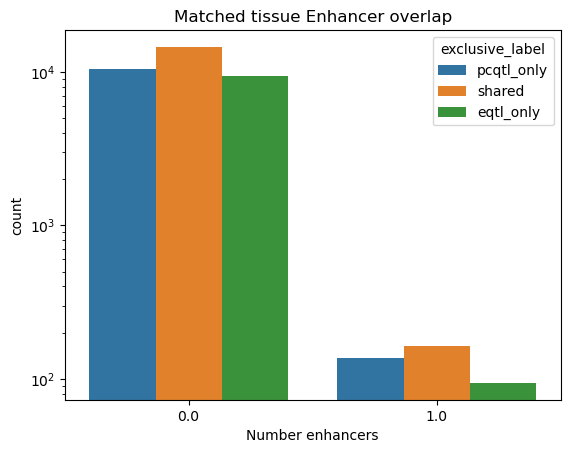

In [207]:
ax = sns.countplot(data=qtls, hue='exclusive_label', x='qtl_num_abc_enhancers')
ax.set_yscale('log')
plt.xlabel('Number enhancers')
plt.title('Matched tissue Enhancer overlap')

Text(0.5, 1.0, 'Matched tissue E-P connections ')

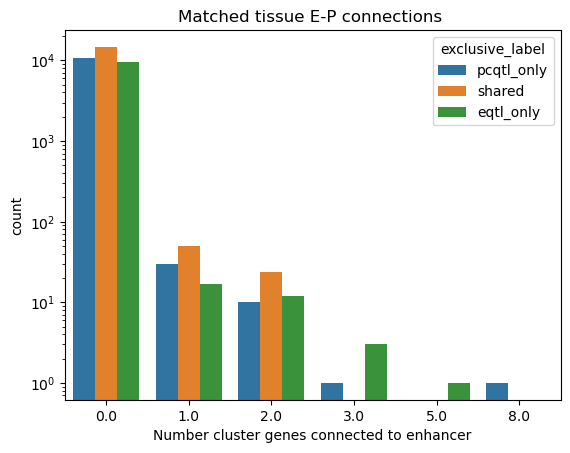

In [221]:
ax = sns.countplot(data=qtls, hue='exclusive_label', x='qtl_matched_abc_genes')
ax.set_yscale('log')

plt.xlabel('Number cluster genes connected to enhancer')
plt.title('Matched tissue E-P connections ')

Text(0.5, 1.0, 'Any tissue E-P connections')

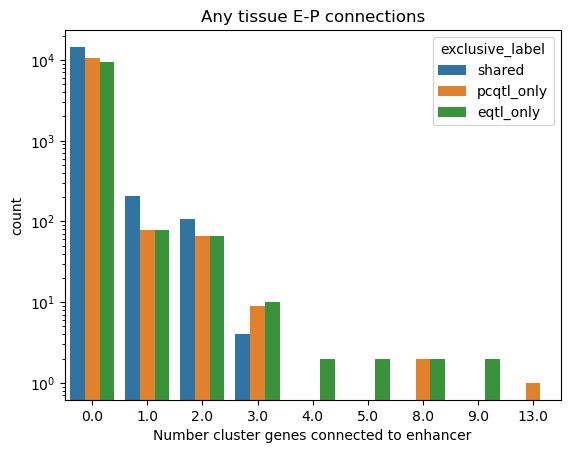

In [218]:
ax = sns.countplot(data=qtls, hue='exclusive_label', x='qtl_matched_abc_all_genes')
ax.set_yscale('log')

plt.xlabel('Number cluster genes connected to enhancer')
plt.title('Any tissue E-P connections')

In [222]:
# very few have any match at all 
qtls[(qtls['qtl_matched_abc_genes']>2)&(qtls['type']=='pcqtl')]['variant_id']


804      chr16_56643842_G_A_b38
20135      chr11_353757_C_T_b38
Name: variant_id, dtype: object

ctcf

In [223]:

qtls['tss_min'] = qtls['position']
qtls['tss_max'] = qtls['position']
qtls['Chromosome'] = qtls['chr']

annotated = []
for tissue_id, sub_qtl in qtls.groupby('tissue_id'):
    ctcf_df = load_ctcf(tissue_id)
    annotate_ctcf(sub_qtl, ctcf_df)
    annotated.append(sub_qtl)

qtls_ctcf =  pd.concat(annotated)

100%|███████████████████████████████████████████████████████████████████████████| 3784/3784 [00:03<00:00, 1188.50it/s]


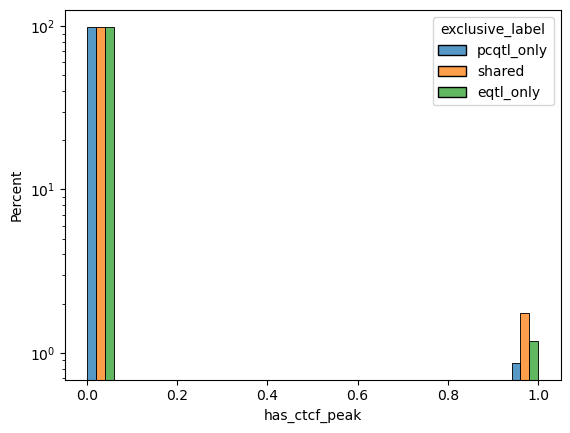

In [357]:
ax = sns.histplot(data=qtls_ctcf, hue='exclusive_label', x='has_ctcf_peak', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')

in a tad?

In [350]:
tad_df = load_tad()
qtls['qtl_inter'] = pd.arrays.IntervalArray.from_arrays(qtls['position'], qtls['position']+1)
qtls['num_tads'] = qtls.progress_apply(count_tad_overlap, axis=1, args=(tad_df, 'qtl_inter'))

  0%|          | 0/34901 [00:00<?, ?it/s]

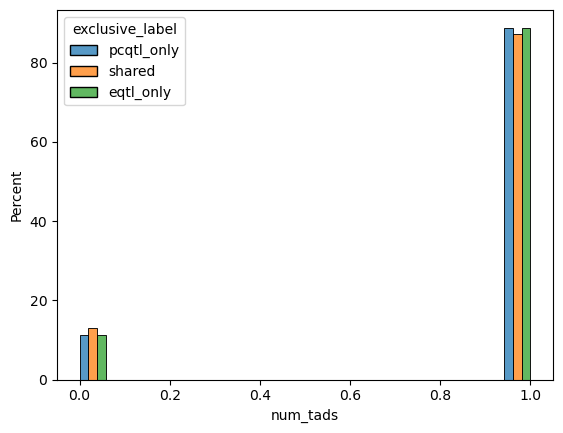

In [358]:
ax = sns.histplot(data=qtls, hue='exclusive_label', x='num_tads', common_norm=False, stat='percent', multiple='dodge')

cluster information

In [447]:
clusters = load_across_tissues(config, load_clusters_annotated)
qtls_cluster_annotated = pd.merge(qtls, clusters, left_on=['cluster_id', 'tissue_id'], right_on=['cluster_id', 'Tissue'])

<AxesSubplot: xlabel='has_high_pos_corr', ylabel='Percent'>

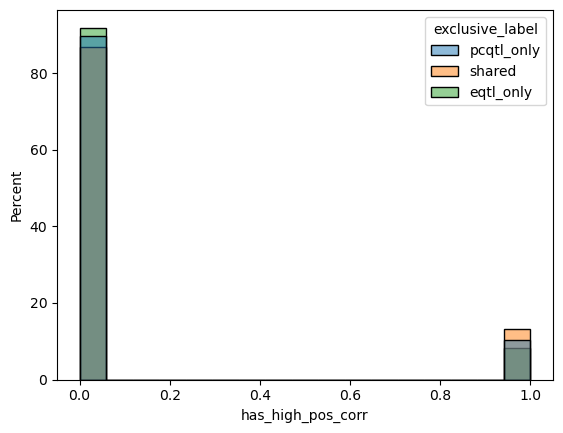

In [233]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='has_high_pos_corr', stat='percent', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Percent'>

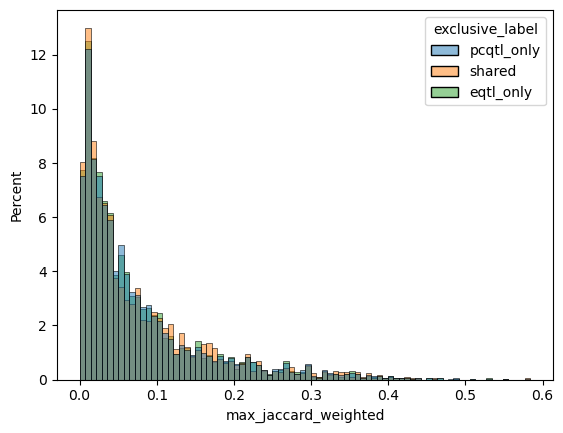

In [234]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['num_abc_genes']>1], hue='exclusive_label', x='max_jaccard_weighted', stat='percent', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Percent'>

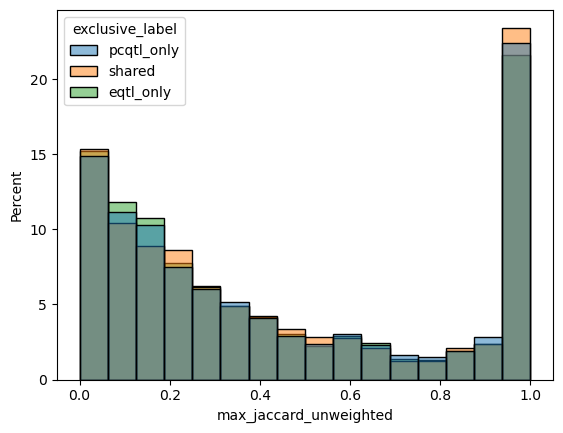

In [235]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['num_abc_genes']>1], hue='exclusive_label', x='max_jaccard_unweighted', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_shared_go_all', ylabel='Percent'>

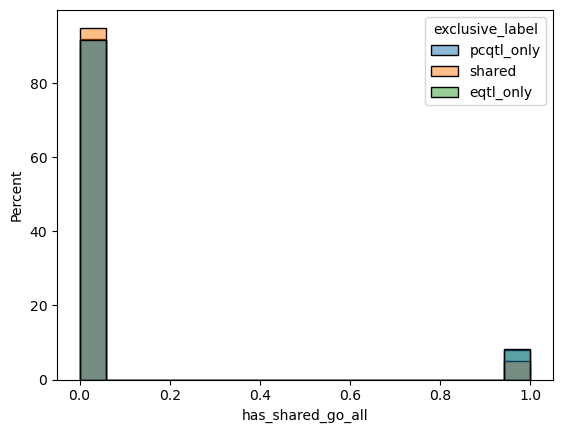

In [236]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='has_shared_go_all', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_cross_map', ylabel='Percent'>

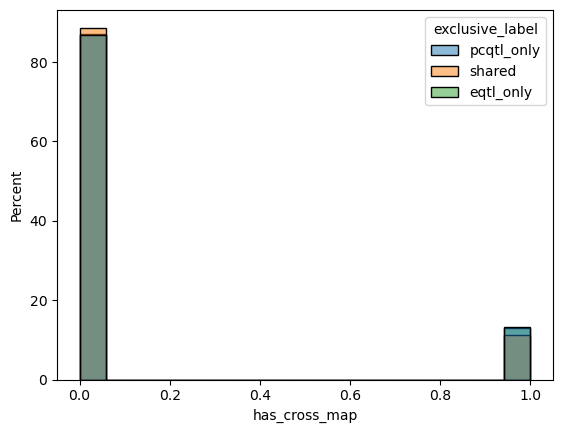

In [237]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='has_cross_map', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_paralog', ylabel='Percent'>

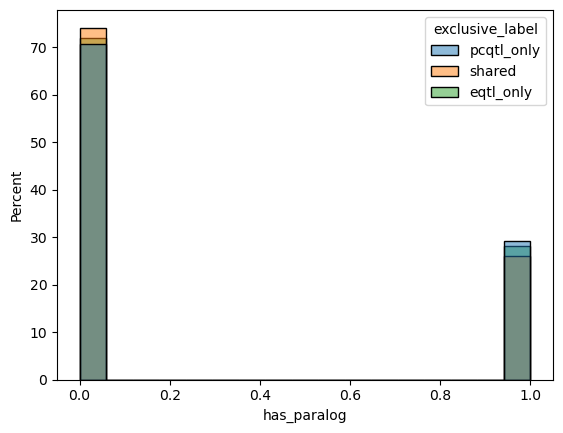

In [238]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='has_paralog', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_shared_strong_enhancers', ylabel='Percent'>

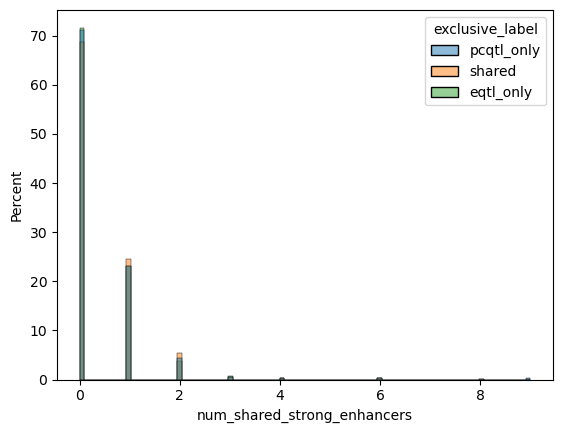

In [239]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['num_abc_genes']>1], hue='exclusive_label', x='num_shared_strong_enhancers', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Percent'>

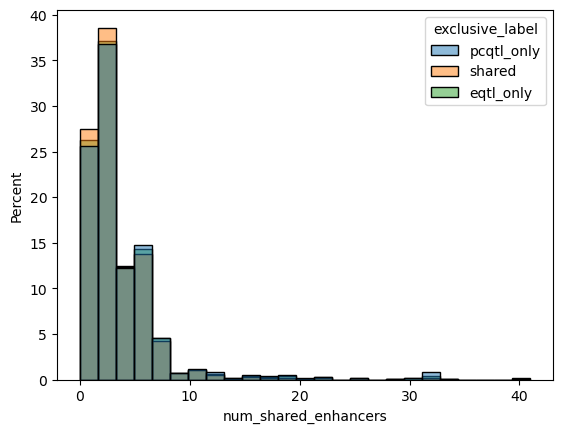

In [242]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['num_abc_genes']>1], hue='exclusive_label', x='num_shared_enhancers', stat='percent', common_norm=False, bins=25)

<AxesSubplot: xlabel='num_tads_tss', ylabel='Percent'>

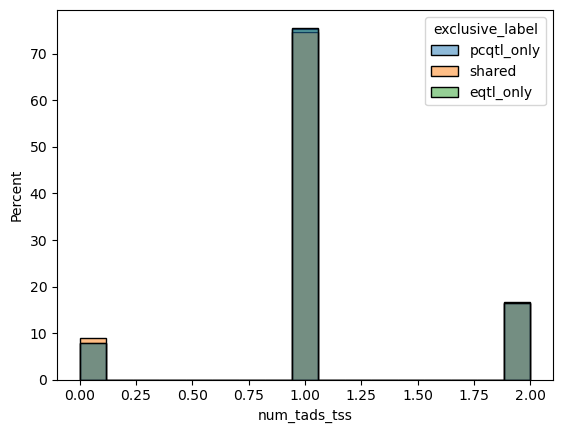

In [243]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='num_tads_tss', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_bidirectional_promoter', ylabel='Percent'>

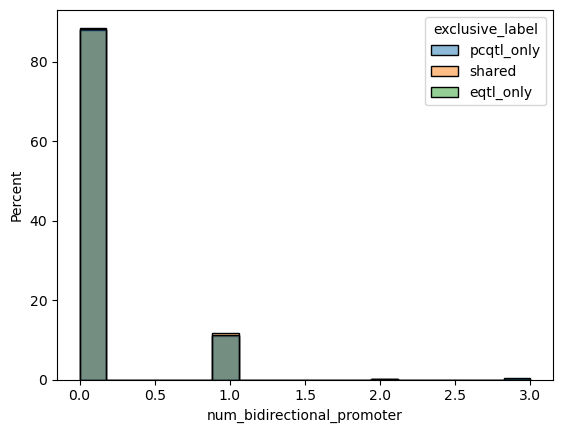

In [244]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='num_bidirectional_promoter', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_abc_genes', ylabel='Percent'>

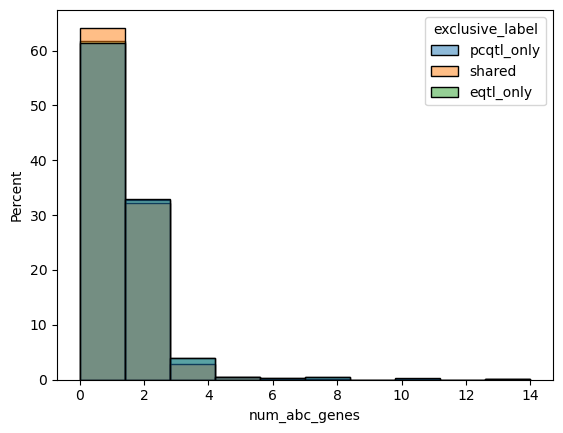

In [431]:
sns.histplot(data=qtls_cluster_annotated, hue='exclusive_label', x='num_abc_genes', stat='percent', common_norm=False, bins=10)

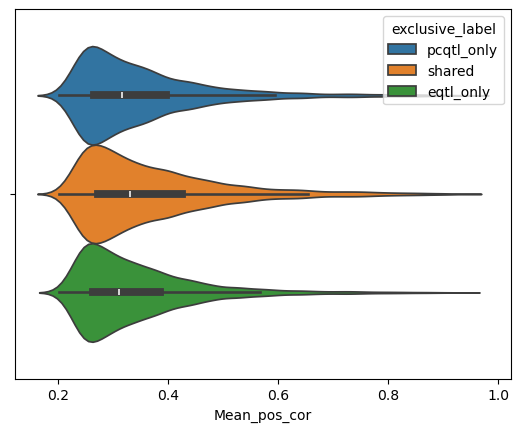

In [433]:
ax=sns.violinplot(data=qtls_cluster_annotated, hue='exclusive_label', x='Mean_pos_cor')


qtl in bidirecitonal promoter

In [451]:
# in a bidirectional promoter?
qtls_cluster_annotated['in_bidirectional_promoter'] = False
sub_qtls = qtls_cluster_annotated[qtls_cluster_annotated['has_bidirectional_promoter']]
for qtl_idx, row in tqdm(sub_qtls.iterrows(), total=len(sub_qtls)):
    transcript_ids = row['cluster_id'].split('_')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    # in the promoter if within 1kb of tss_start
    for idx, first_gene_row in cluster_gencode.iterrows():
        for idx, second_gene_row in cluster_gencode.iterrows():
            opp_strand = first_gene_row['strand'] != second_gene_row['strand']
            close = abs(first_gene_row['tss_start'] - second_gene_row['tss_start']) <= 1000
            if opp_strand & close:
                # found a bidirectional promotor
                if ((row['position'] - first_gene_row['tss_start']) < 1000) | ((row['position'] - second_gene_row['tss_start']) < 1000):
                    qtls_cluster_annotated.loc[qtl_idx, 'in_bidirectional_promoter'] = True

  0%|          | 0/4068 [00:00<?, ?it/s]

<AxesSubplot: xlabel='in_bidirectional_promoter', ylabel='Percent'>

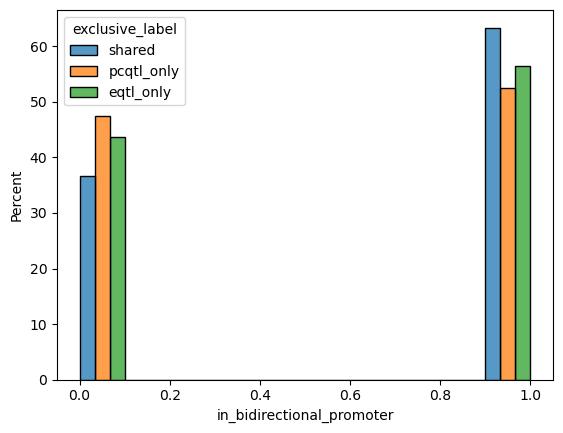

In [455]:
sns.histplot(data=qtls_cluster_annotated[qtls_cluster_annotated['has_bidirectional_promoter']], hue='exclusive_label', x='in_bidirectional_promoter', stat='percent', common_norm=False, bins=10, multiple='dodge')